In [51]:
!pip install shap

In [52]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, classification_report, roc_auc_score, roc_curve)
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import joblib
import shap

import warnings
warnings.filterwarnings('ignore')

# DATASET OVERVIEW

In [54]:


df = pd.read_csv(r"C:\Users\dmade\Downloads\Sleep_health_and_lifestyle_dataset.csv")
df

# Set up visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")



print("=" * 50)
print("DATASET OVERVIEW")
print("=" * 50)

# Basic information about the dataset
print(f"Dataset Shape: {df.shape}")
print(f"\nColumn Names: {list(df.columns)}")
print(f"\nData Types:\n{df.dtypes}")

# Display first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())



DATASET OVERVIEW
Dataset Shape: (374, 13)

Column Names: ['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder']

Data Types:
Person ID                    int64
Gender                      object
Age                          int64
Occupation                  object
Sleep Duration             float64
Quality of Sleep             int64
Physical Activity Level      int64
Stress Level                 int64
BMI Category                object
Blood Pressure              object
Heart Rate                   int64
Daily Steps                  int64
Sleep Disorder              object
dtype: object

First 5 rows of the dataset:
   Person ID Gender  Age            Occupation  Sleep Duration  \
0          1   Male   27     Software Engineer             6.1   
1          2   Male   28                Doctor             6.2   
2          3   Male   28  

In [55]:
print("\n" + "=" * 50)
print("DATA QUALITY CHECK")
print("=" * 50)

# Check for missing values
print("Missing Values:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])



DATA QUALITY CHECK
Missing Values:
Sleep Disorder    219
dtype: int64


In [56]:
# Check for duplicates
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")


Number of duplicate rows: 0


In [57]:
# Basic statistics
print("\nBasic Statistics:")
df.describe(include='all')


Basic Statistics:


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
count,374.000000,374,374.000000,374,374.000000,374.000000,374.000000,374.000000,374,374,374.000000,374.000000,155
unique,NaN,2,NaN,11,NaN,NaN,NaN,NaN,4,25,NaN,NaN,2
top,NaN,Male,NaN,Nurse,NaN,NaN,NaN,NaN,Normal,130/85,NaN,NaN,Sleep Apnea
freq,NaN,189,NaN,73,NaN,NaN,NaN,NaN,195,99,NaN,NaN,78
mean,187.500000,NaN,42.184492,NaN,7.132086,7.312834,59.171123,5.385027,NaN,NaN,70.165775,6816.844920,NaN
std,108.108742,NaN,8.673133,NaN,0.795657,1.196956,20.830804,1.774526,NaN,NaN,4.135676,1617.915679,NaN
min,1.000000,NaN,27.000000,NaN,5.800000,4.000000,30.000000,3.000000,NaN,NaN,65.000000,3000.000000,NaN
25%,94.250000,NaN,35.250000,NaN,6.400000,6.000000,45.000000,4.000000,NaN,NaN,68.000000,5600.000000,NaN
50%,187.500000,NaN,43.000000,NaN,7.200000,7.000000,60.000000,5.000000,NaN,NaN,70.000000,7000.000000,NaN
75%,280.750000,NaN,50.000000,NaN,7.800000,8.000000,75.000000,7.000000,NaN,NaN,72.000000,8000.000000,NaN


# FEATURE ENGINEERING

In [59]:
print("\n" + "=" * 50)
print("FEATURE ENGINEERING")
print("=" * 50)

# Create a copy for preprocessing
df_processed = df.copy()

# 1. Split Blood Pressure into Systolic and Diastolic
print("Splitting Blood Pressure column...")
df_processed[['Systolic_BP', 'Diastolic_BP']] = df_processed['Blood Pressure'].str.split('/', expand=True)
df_processed['Systolic_BP'] = df_processed['Systolic_BP'].astype(int)
df_processed['Diastolic_BP'] = df_processed['Diastolic_BP'].astype(int)

# 2. Create Age Groups
print("Creating Age Groups...")
bins = [20, 30, 40, 50, 60, 100]
labels = ['20-29', '30-39', '40-49', '50-59', '60+']
df_processed['Age_Group'] = pd.cut(df_processed['Age'], bins=bins, labels=labels, right=False)

# 3. Create Sleep Quality Categories
print("Creating Sleep Quality Categories...")
sleep_quality_bins = [0, 5, 7, 10]
sleep_quality_labels = ['Poor', 'Average', 'Good']
df_processed['Sleep_Quality_Category'] = pd.cut(df_processed['Quality of Sleep'], 
                                              bins=sleep_quality_bins, 
                                              labels=sleep_quality_labels)

# 4. Create Stress Level Categories
print("Creating Stress Level Categories...")
stress_bins = [0, 4, 7, 10]
stress_labels = ['Low', 'Medium', 'High']
df_processed['Stress_Level_Category'] = pd.cut(df_processed['Stress Level'], 
                                             bins=stress_bins, 
                                             labels=stress_labels)

# Display the new features
print("\nNew features created:")
new_features = ['Systolic_BP', 'Diastolic_BP', 'Age_Group', 'Sleep_Quality_Category', 'Stress_Level_Category']
print(df_processed[new_features].head())



FEATURE ENGINEERING
Splitting Blood Pressure column...
Creating Age Groups...
Creating Sleep Quality Categories...
Creating Stress Level Categories...

New features created:
   Systolic_BP  Diastolic_BP Age_Group Sleep_Quality_Category  \
0          126            83     20-29                Average   
1          125            80     20-29                Average   
2          125            80     20-29                Average   
3          140            90     20-29                   Poor   
4          140            90     20-29                   Poor   

  Stress_Level_Category  
0                Medium  
1                  High  
2                  High  
3                  High  
4                  High  



EXPLORATORY DATA ANALYSIS (EDA)
1. Target Variable Distribution - Sleep Disorder


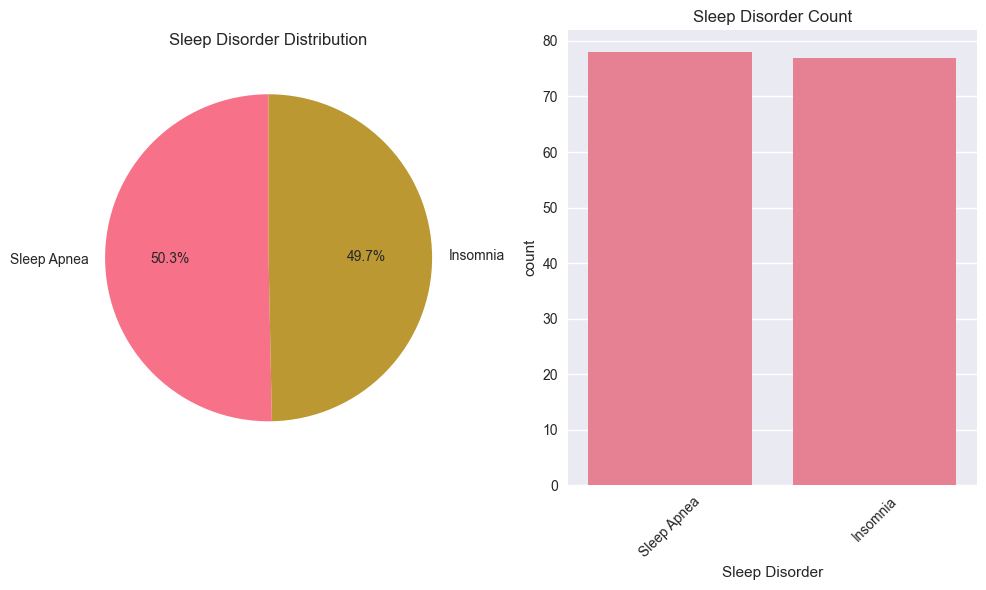


Sleep Disorder Counts:
Sleep Disorder
Sleep Apnea    78
Insomnia       77
Name: count, dtype: int64


In [60]:
print("\n" + "=" * 50)
print("EXPLORATORY DATA ANALYSIS (EDA)")
print("=" * 50)

# 1. Target Variable Distribution
print("1. Target Variable Distribution - Sleep Disorder")
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sleep_disorder_counts = df_processed['Sleep Disorder'].value_counts()
plt.pie(sleep_disorder_counts.values, labels=sleep_disorder_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Sleep Disorder Distribution')

plt.subplot(1, 2, 2)
sns.countplot(data=df_processed, x='Sleep Disorder')
plt.title('Sleep Disorder Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nSleep Disorder Counts:\n{sleep_disorder_counts}")



2. Demographic Analysis


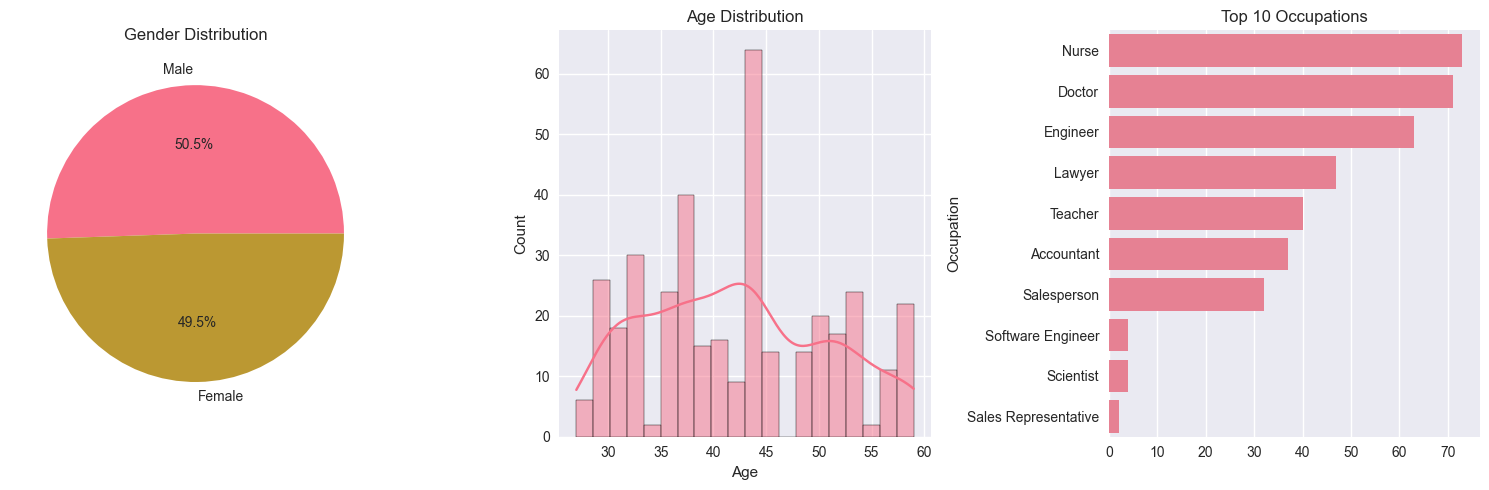

In [61]:
# 2. Demographic Analysis
print("\n2. Demographic Analysis")

# Gender distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
gender_counts = df_processed['Gender'].value_counts()
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%')
plt.title('Gender Distribution')

# Age distribution
plt.subplot(1, 3, 2)
sns.histplot(data=df_processed, x='Age', bins=20, kde=True)
plt.title('Age Distribution')

# Occupation distribution (top 10)
plt.subplot(1, 3, 3)
top_occupations = df_processed['Occupation'].value_counts().head(10)
sns.barplot(y=top_occupations.index, x=top_occupations.values)
plt.title('Top 10 Occupations')
plt.tight_layout()
plt.show()


3. Sleep-related Features Analysis


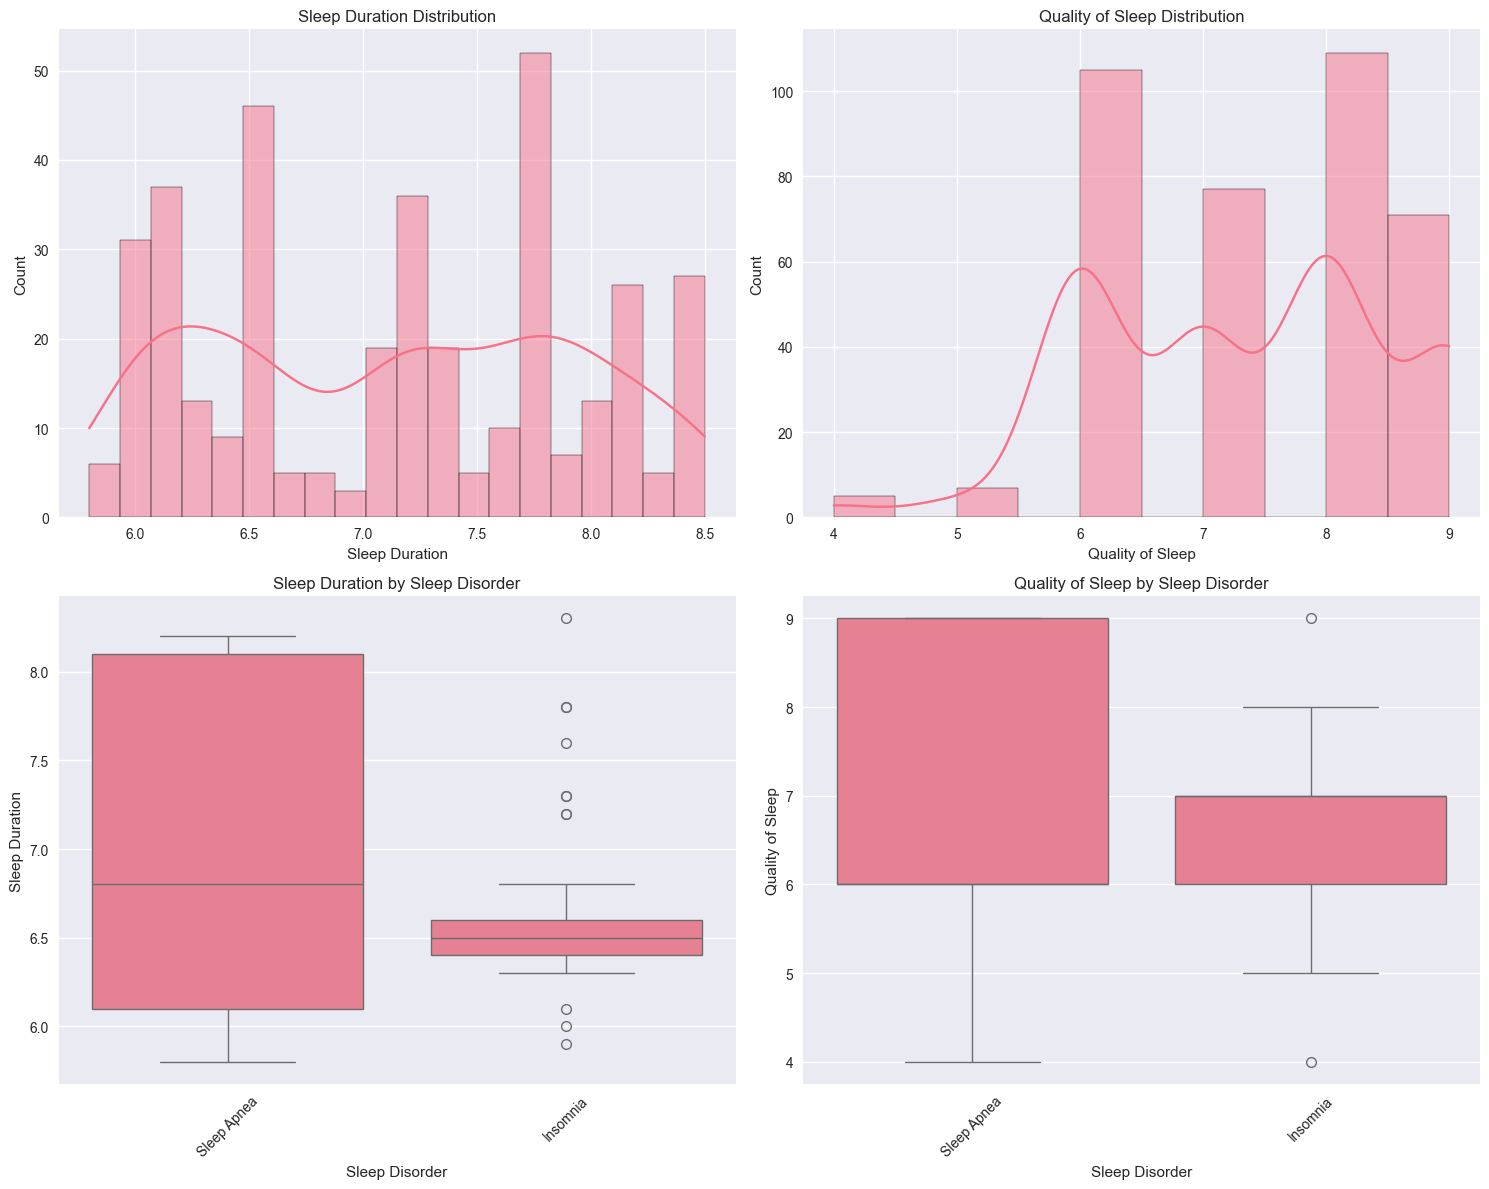

In [62]:
# 3. Sleep-related Features Analysis
print("\n3. Sleep-related Features Analysis")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Sleep Duration
sns.histplot(data=df_processed, x='Sleep Duration', bins=20, kde=True, ax=axes[0,0])
axes[0,0].set_title('Sleep Duration Distribution')

# Quality of Sleep
sns.histplot(data=df_processed, x='Quality of Sleep', bins=10, kde=True, ax=axes[0,1])
axes[0,1].set_title('Quality of Sleep Distribution')

# Sleep Duration vs Sleep Disorder
sns.boxplot(data=df_processed, x='Sleep Disorder', y='Sleep Duration', ax=axes[1,0])
axes[1,0].set_title('Sleep Duration by Sleep Disorder')
axes[1,0].tick_params(axis='x', rotation=45)

# Quality of Sleep vs Sleep Disorder
sns.boxplot(data=df_processed, x='Sleep Disorder', y='Quality of Sleep', ax=axes[1,1])
axes[1,1].set_title('Quality of Sleep by Sleep Disorder')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



4. Lifestyle Factors Analysis


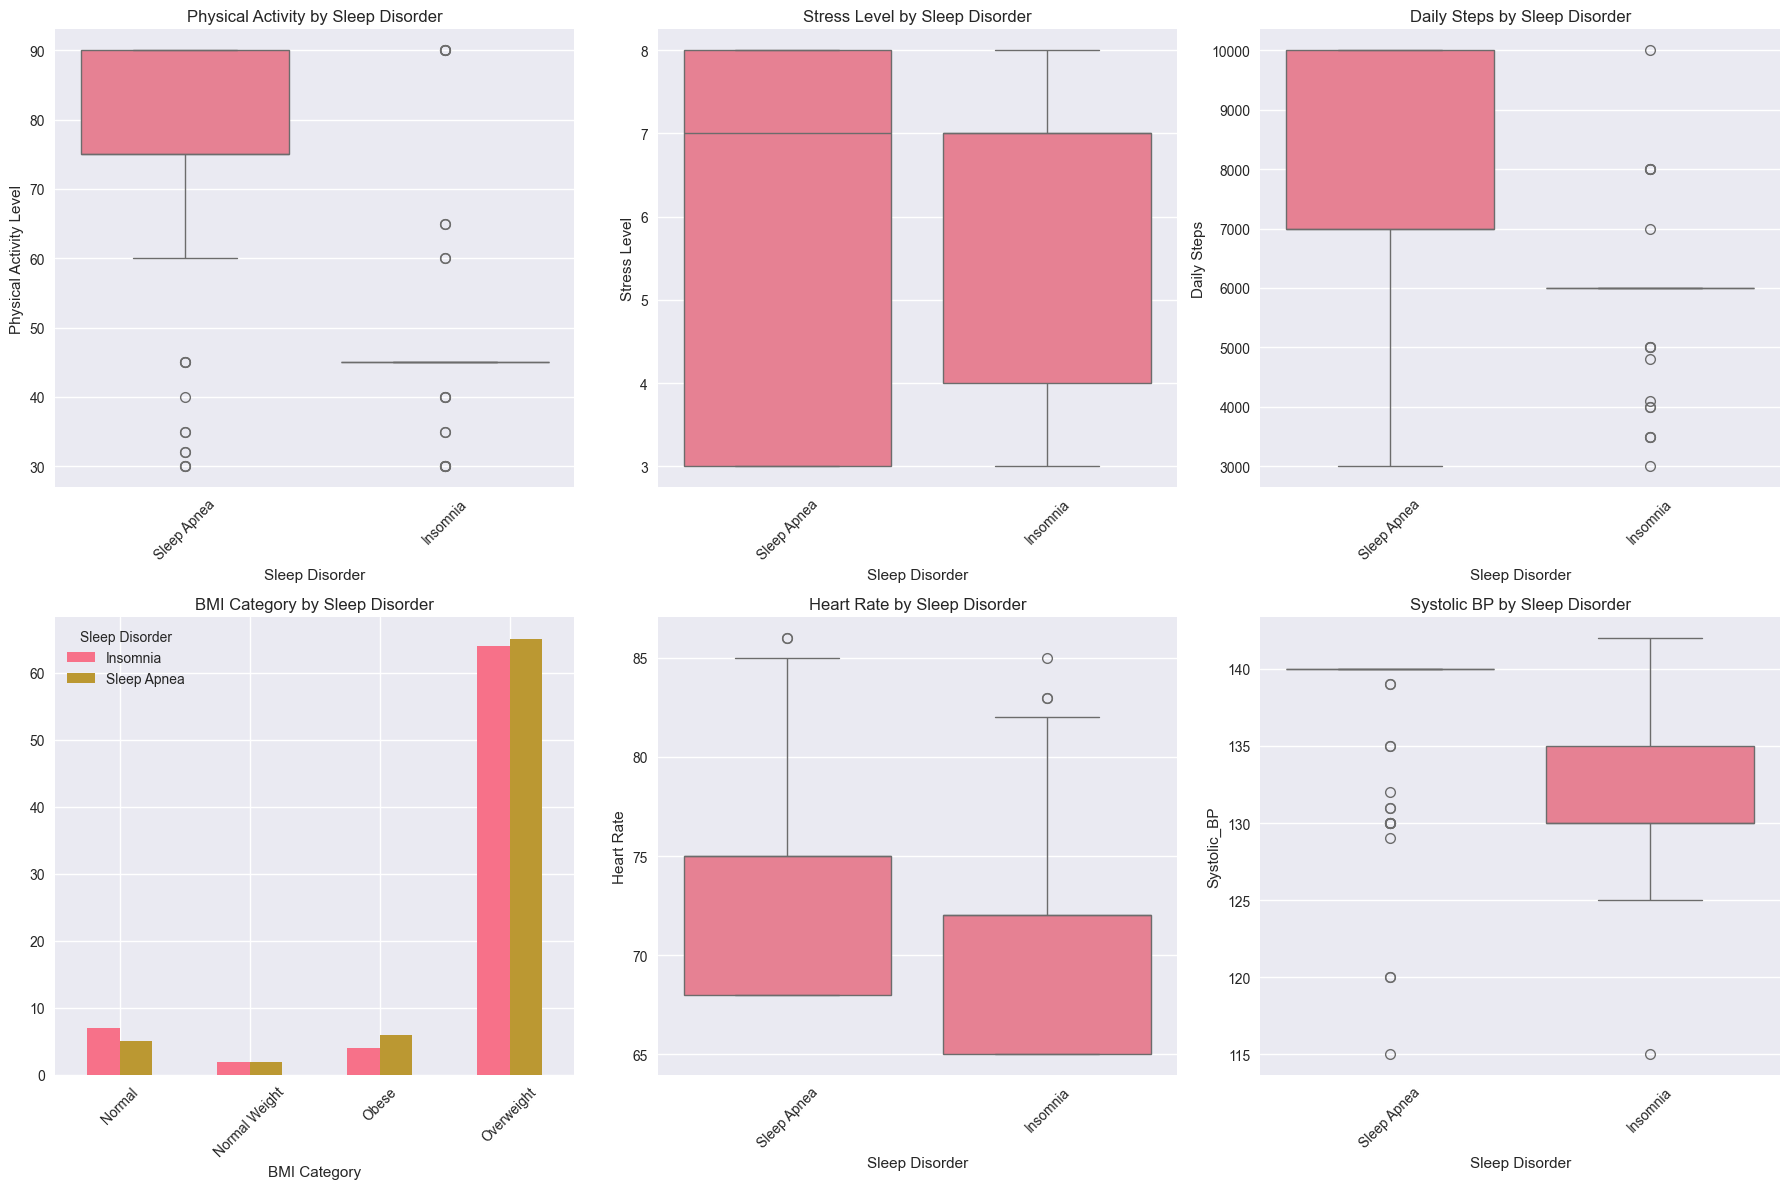

In [63]:
# 4. Lifestyle Factors Analysis
print("\n4. Lifestyle Factors Analysis")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Physical Activity Level
sns.boxplot(data=df_processed, x='Sleep Disorder', y='Physical Activity Level', ax=axes[0,0])
axes[0,0].set_title('Physical Activity by Sleep Disorder')
axes[0,0].tick_params(axis='x', rotation=45)

# Stress Level
sns.boxplot(data=df_processed, x='Sleep Disorder', y='Stress Level', ax=axes[0,1])
axes[0,1].set_title('Stress Level by Sleep Disorder')
axes[0,1].tick_params(axis='x', rotation=45)

# Daily Steps
sns.boxplot(data=df_processed, x='Sleep Disorder', y='Daily Steps', ax=axes[0,2])
axes[0,2].set_title('Daily Steps by Sleep Disorder')
axes[0,2].tick_params(axis='x', rotation=45)

# BMI Category
bmi_sleep_disorder = pd.crosstab(df_processed['BMI Category'], df_processed['Sleep Disorder'])
bmi_sleep_disorder.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('BMI Category by Sleep Disorder')
axes[1,0].tick_params(axis='x', rotation=45)

# Heart Rate
sns.boxplot(data=df_processed, x='Sleep Disorder', y='Heart Rate', ax=axes[1,1])
axes[1,1].set_title('Heart Rate by Sleep Disorder')
axes[1,1].tick_params(axis='x', rotation=45)

# Blood Pressure - Systolic
sns.boxplot(data=df_processed, x='Sleep Disorder', y='Systolic_BP', ax=axes[1,2])
axes[1,2].set_title('Systolic BP by Sleep Disorder')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


5. Correlation Analysis


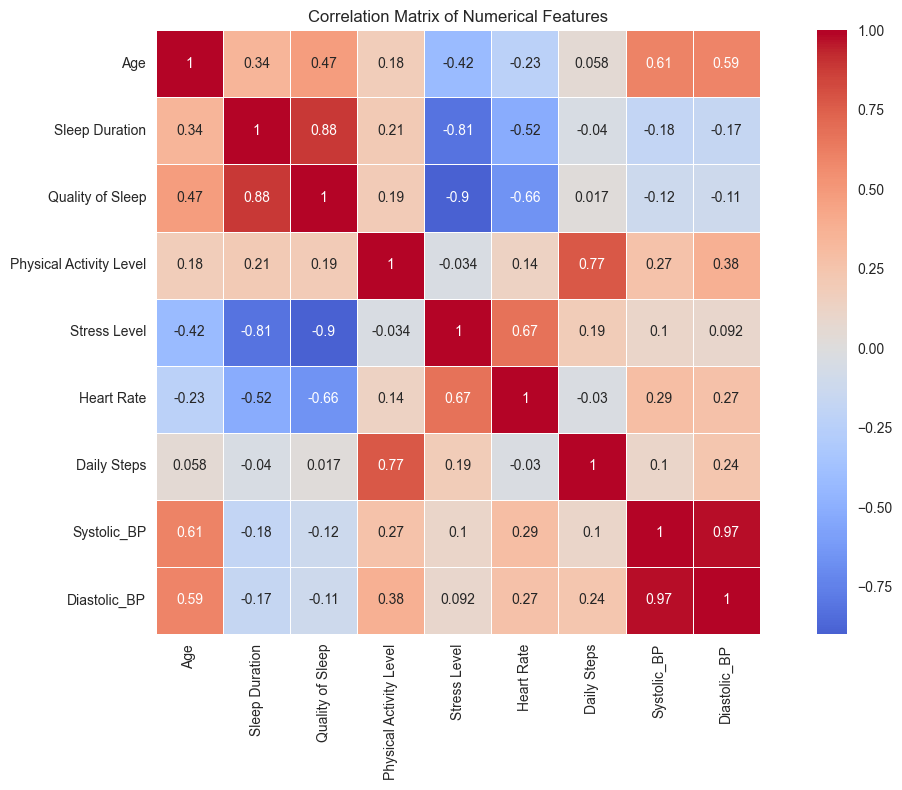

In [64]:
# 5. Correlation Analysis
print("\n5. Correlation Analysis")

# Select numerical features for correlation matrix
numerical_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 
                     'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic_BP', 'Diastolic_BP']

plt.figure(figsize=(12, 8))
correlation_matrix = df_processed[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

In [65]:
# 6. Cross-tabulation Analysis
print("\n6. Cross-tabulation Analysis")

# Gender vs Sleep Disorder
print("Gender vs Sleep Disorder:")
gender_sleep = pd.crosstab(df_processed['Gender'], df_processed['Sleep Disorder'], normalize='index') * 100
print(gender_sleep.round(2))
print()

# BMI Category vs Sleep Disorder
print("BMI Category vs Sleep Disorder:")
bmi_sleep = pd.crosstab(df_processed['BMI Category'], df_processed['Sleep Disorder'], normalize='index') * 100
print(bmi_sleep.round(2))
print()

# Occupation vs Sleep Disorder (Top 5 occupations)
print("Occupation vs Sleep Disorder (Top 5 occupations):")
top_5_occupations = df_processed['Occupation'].value_counts().head(5).index
occupation_sleep = pd.crosstab(df_processed[df_processed['Occupation'].isin(top_5_occupations)]['Occupation'], 
                              df_processed[df_processed['Occupation'].isin(top_5_occupations)]['Sleep Disorder'],
                              normalize='index') * 100
print(occupation_sleep.round(2))


6. Cross-tabulation Analysis
Gender vs Sleep Disorder:
Sleep Disorder  Insomnia  Sleep Apnea
Gender                               
Female             34.95        65.05
Male               78.85        21.15

BMI Category vs Sleep Disorder:
Sleep Disorder  Insomnia  Sleep Apnea
BMI Category                         
Normal             58.33        41.67
Normal Weight      50.00        50.00
Obese              40.00        60.00
Overweight         49.61        50.39

Occupation vs Sleep Disorder (Top 5 occupations):
Sleep Disorder  Insomnia  Sleep Apnea
Occupation                           
Doctor             42.86        57.14
Engineer           83.33        16.67
Lawyer             40.00        60.00
Nurse               4.69        95.31
Teacher            87.10        12.90


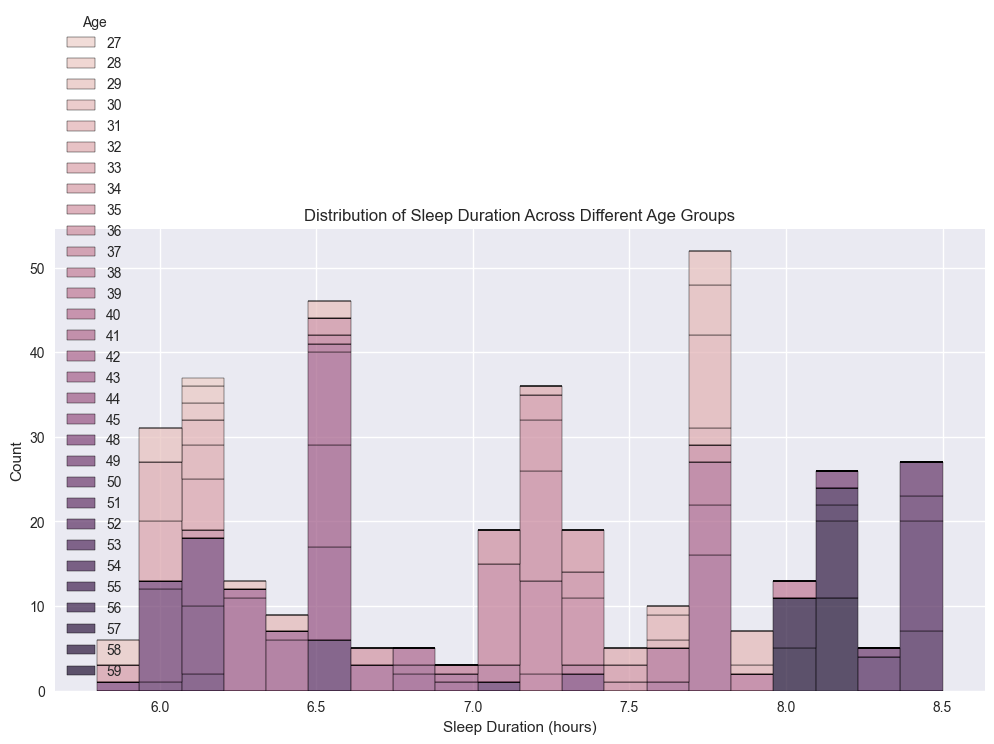

In [66]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Sleep Duration', hue='Age', multiple='stack', bins=20)
plt.title('Distribution of Sleep Duration Across Different Age Groups')
plt.xlabel('Sleep Duration (hours)')
plt.ylabel('Count')
plt.show()

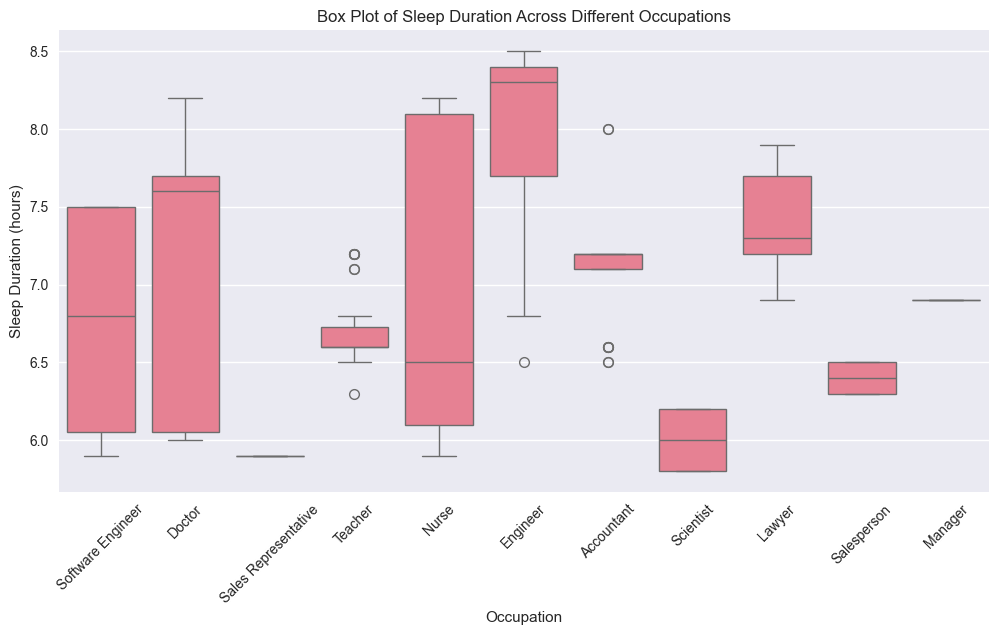

In [67]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Occupation', y='Sleep Duration')
plt.title('Box Plot of Sleep Duration Across Different Occupations')
plt.xlabel('Occupation')
plt.ylabel('Sleep Duration (hours)')
plt.xticks(rotation=45)
plt.show()

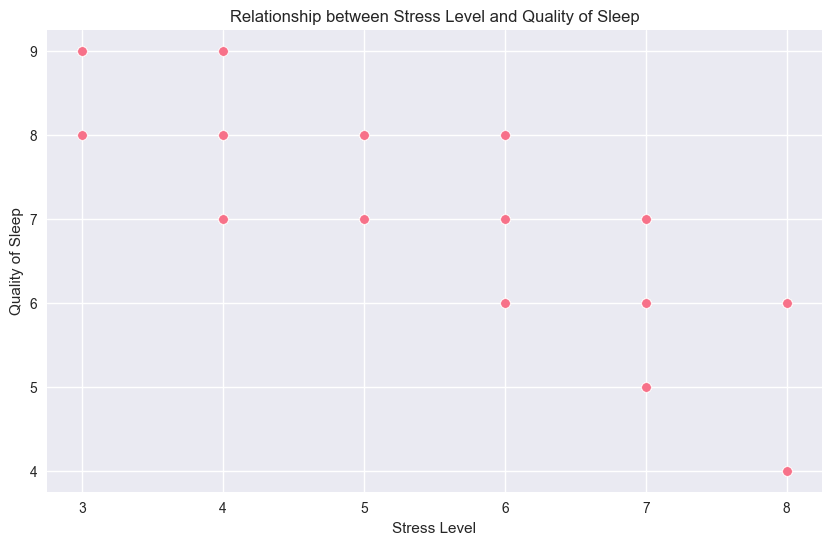

In [68]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Stress Level', y='Quality of Sleep')
plt.title('Relationship between Stress Level and Quality of Sleep')
plt.xlabel('Stress Level')
plt.ylabel('Quality of Sleep')
plt.show()

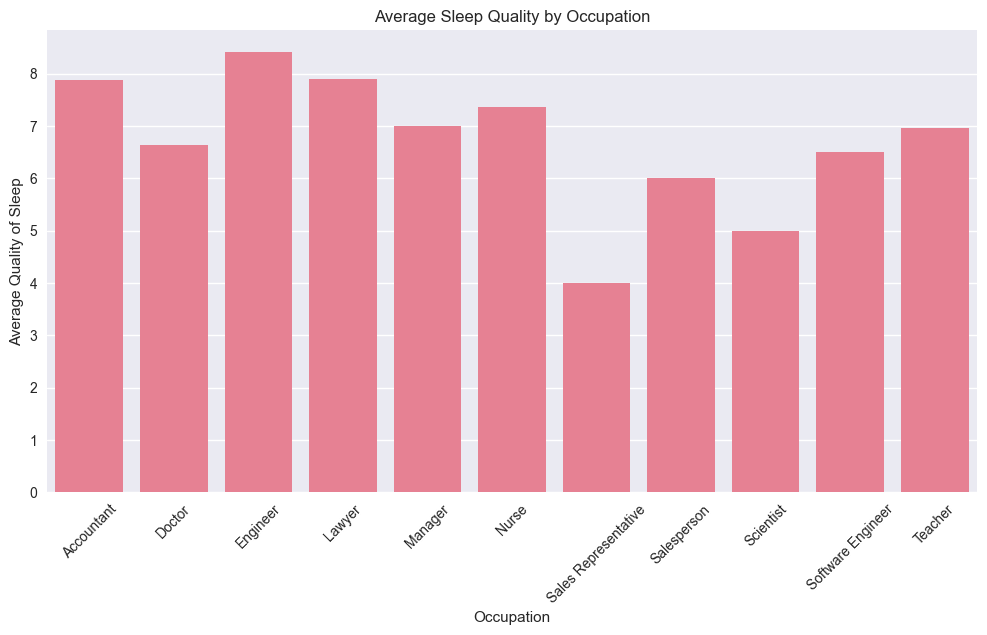

In [69]:

# Grouping the data by occupation and calculating the mean sleep quality
occupation_sleep_quality = df.groupby('Occupation')['Quality of Sleep'].mean().reset_index()

# Plotting the results
plt.figure(figsize=(12, 6))
sns.barplot(data=occupation_sleep_quality, x='Occupation', y='Quality of Sleep')
plt.title('Average Sleep Quality by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Average Quality of Sleep')
plt.xticks(rotation=45)
plt.show()

# DATA PREPARATION

In [71]:
print("\n" + "=" * 50)
print("DATA PREPARATION FOR MACHINE LEARNING")
print("=" * 50)

# Prepare features for modeling
features_for_ml = df_processed.copy()

# Encode categorical variables
print("Encoding categorical variables...")
categorical_columns = ['Gender', 'Occupation', 'BMI Category', 'Age_Group', 
                      'Sleep_Quality_Category', 'Stress_Level_Category']

label_encoders = {}
for col in categorical_columns:
    if col in features_for_ml.columns:
        le = LabelEncoder()
        features_for_ml[col + '_encoded'] = le.fit_transform(features_for_ml[col].astype(str))
        label_encoders[col] = le

# Encode target variable
target_encoder = LabelEncoder()
features_for_ml['Sleep_Disorder_encoded'] = target_encoder.fit_transform(features_for_ml['Sleep Disorder'])

# Define feature set and target variable
feature_columns = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level',
                  'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic_BP', 'Diastolic_BP'] + \
                 [col + '_encoded' for col in categorical_columns]

X = features_for_ml[feature_columns]
y = features_for_ml['Sleep_Disorder_encoded']

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Feature names: {list(X.columns)}")


DATA PREPARATION FOR MACHINE LEARNING
Encoding categorical variables...
Feature matrix shape: (374, 15)
Target variable shape: (374,)
Feature names: ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic_BP', 'Diastolic_BP', 'Gender_encoded', 'Occupation_encoded', 'BMI Category_encoded', 'Age_Group_encoded', 'Sleep_Quality_Category_encoded', 'Stress_Level_Category_encoded']


In [72]:

# Display the prepared data
print("\nFirst 5 rows of prepared features:")
print(X.head())




First 5 rows of prepared features:
   Age  Sleep Duration  Quality of Sleep  Physical Activity Level  \
0   27             6.1                 6                       42   
1   28             6.2                 6                       60   
2   28             6.2                 6                       60   
3   28             5.9                 4                       30   
4   28             5.9                 4                       30   

   Stress Level  Heart Rate  Daily Steps  Systolic_BP  Diastolic_BP  \
0             6          77         4200          126            83   
1             8          75        10000          125            80   
2             8          75        10000          125            80   
3             8          85         3000          140            90   
4             8          85         3000          140            90   

   Gender_encoded  Occupation_encoded  BMI Category_encoded  \
0               1                   9                     3

In [73]:
print("\nTarget variable distribution (encoded):")
print(pd.Series(y).value_counts())
print("Mapping:", dict(enumerate(target_encoder.classes_)))


Target variable distribution (encoded):
Sleep_Disorder_encoded
2    219
1     78
0     77
Name: count, dtype: int64
Mapping: {0: 'Insomnia', 1: 'Sleep Apnea', 2: nan}


In [74]:
print("\n" + "=" * 50)
print("SUMMARY STATISTICS")
print("=" * 50)

print("Dataset Summary:")
print(f"- Total samples: {len(df_processed)}")
print(f"- Number of features: {len(feature_columns)}")
print(f"- Sleep Disorder classes: {df_processed['Sleep Disorder'].nunique()}")
print(f"- Gender distribution: {df_processed['Gender'].value_counts().to_dict()}")
print(f"- Age range: {df_processed['Age'].min()} - {df_processed['Age'].max()}")
print(f"- Average sleep duration: {df_processed['Sleep Duration'].mean():.2f} hours")
print(f"- Average sleep quality: {df_processed['Quality of Sleep'].mean():.2f}/10")

print("\nKey Insights from EDA:")
print("1. Check the sleep disorder distribution for class imbalance")
print("2. Note the relationships between lifestyle factors and sleep disorders")
print("3. Observe which features show strong correlations with sleep quality")
print("4. Identify potential important predictors for the ML model")

# Save the processed dataset
df_processed.to_csv('sleep_health_processed.csv', index=False)
print(f"\nProcessed dataset saved as 'sleep_health_processed.csv'")


SUMMARY STATISTICS
Dataset Summary:
- Total samples: 374
- Number of features: 15
- Sleep Disorder classes: 2
- Gender distribution: {'Male': 189, 'Female': 185}
- Age range: 27 - 59
- Average sleep duration: 7.13 hours
- Average sleep quality: 7.31/10

Key Insights from EDA:
1. Check the sleep disorder distribution for class imbalance
2. Note the relationships between lifestyle factors and sleep disorders
3. Observe which features show strong correlations with sleep quality
4. Identify potential important predictors for the ML model

Processed dataset saved as 'sleep_health_processed.csv'


# MODEL SELECTION & TRAINING

In [76]:
print("=" * 60)
print("PHASE 2: MODEL SELECTION & TRAINING")
print("PHASE 3: MODEL EVALUATION")
print("=" * 60)

# Load the preprocessed data
print("Loading preprocessed data...")
df_processed = pd.read_csv('sleep_health_processed.csv')

# Prepare features and target
print("\nPreparing features and target variable...")

# Define feature columns (adjust based on your preprocessing)
feature_columns = [
    'Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level',
    'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic_BP', 'Diastolic_BP'
]

# Add encoded categorical columns
categorical_columns = ['Gender', 'Occupation', 'BMI Category', 'Age_Group', 
                      'Sleep_Quality_Category', 'Stress_Level_Category']

for col in categorical_columns:
    if f"{col}_encoded" in df_processed.columns:
        feature_columns.append(f"{col}_encoded")

X = df_processed[feature_columns]
y = df_processed['Sleep Disorder']  # Original labels for interpretation

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y_encoded.shape}")
print(f"Classes: {label_encoder.classes_}")


PHASE 2: MODEL SELECTION & TRAINING
PHASE 3: MODEL EVALUATION
Loading preprocessed data...

Preparing features and target variable...
Feature matrix shape: (374, 9)
Target variable shape: (374,)
Classes: ['Insomnia' 'Sleep Apnea' nan]


In [77]:

# Split the data
print("\nSplitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Splitting data into train and test sets...
Training set: 299 samples
Test set: 75 samples


In [78]:
# Scale the features
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Scaling features...


In [79]:
print("=" * 60)
print("MODEL TRAINING & EVALUATION")
print("=" * 60)

# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'SVM': SVC(random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Dictionary to store results
results = {
    'Model': [],
    'Accuracy': [],
    'Precision (Macro)': [],
    'Recall (Macro)': [],
    'F1-Score (Macro)': [],
    'Cross-Val Score (Mean)': [],
    'Cross-Val Score (Std)': []
}

# Train and evaluate each model
print("Training and evaluating models...\n")

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f"➤ Training {model_name}...")
    
    # Use scaled features for models that benefit from scaling
    if model_name in ['Logistic Regression', 'SVM', 'K-Nearest Neighbors']:
        X_train_used = X_train_scaled
        X_test_used = X_test_scaled
    else:
        X_train_used = X_train
        X_test_used = X_test
    
    # Train model
    model.fit(X_train_used, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_used)
    y_pred_proba = model.predict_proba(X_test_used) if hasattr(model, "predict_proba") else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train_used, y_train, cv=cv, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # Store results
    results['Model'].append(model_name)
    results['Accuracy'].append(accuracy)
    results['Precision (Macro)'].append(precision)
    results['Recall (Macro)'].append(recall)
    results['F1-Score (Macro)'].append(f1)
    results['Cross-Val Score (Mean)'].append(cv_mean)
    results['Cross-Val Score (Std)'].append(cv_std)
    
    print(f"   ✅ Completed - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")

# Create results dataframe
results_df = pd.DataFrame(results)


MODEL TRAINING & EVALUATION
Training and evaluating models...

➤ Training Logistic Regression...
   ✅ Completed - Accuracy: 0.8800, F1-Score: 0.8299
➤ Training Random Forest...
   ✅ Completed - Accuracy: 0.9200, F1-Score: 0.8936
➤ Training Gradient Boosting...
   ✅ Completed - Accuracy: 0.9200, F1-Score: 0.8936
➤ Training XGBoost...
   ✅ Completed - Accuracy: 0.9200, F1-Score: 0.8936
➤ Training SVM...
   ✅ Completed - Accuracy: 0.8933, F1-Score: 0.8511
➤ Training K-Nearest Neighbors...
   ✅ Completed - Accuracy: 0.8933, F1-Score: 0.8507



MODEL PERFORMANCE COMPARISON
                 Model  Accuracy  Precision (Macro)  Recall (Macro)  \
1        Random Forest    0.9200             0.8890          0.8987   
2    Gradient Boosting    0.9200             0.8890          0.8987   
3              XGBoost    0.9200             0.8890          0.8987   
4                  SVM    0.8933             0.8472          0.8557   
5  K-Nearest Neighbors    0.8933             0.8472          0.8571   
0  Logistic Regression    0.8800             0.8256          0.8348   

   F1-Score (Macro)  Cross-Val Score (Mean)  Cross-Val Score (Std)  
1            0.8936                  0.8865                 0.0617  
2            0.8936                  0.8865                 0.0668  
3            0.8936                  0.8765                 0.0571  
4            0.8511                  0.9132                 0.0384  
5            0.8507                  0.8931                 0.0427  
0            0.8299                  0.9065               

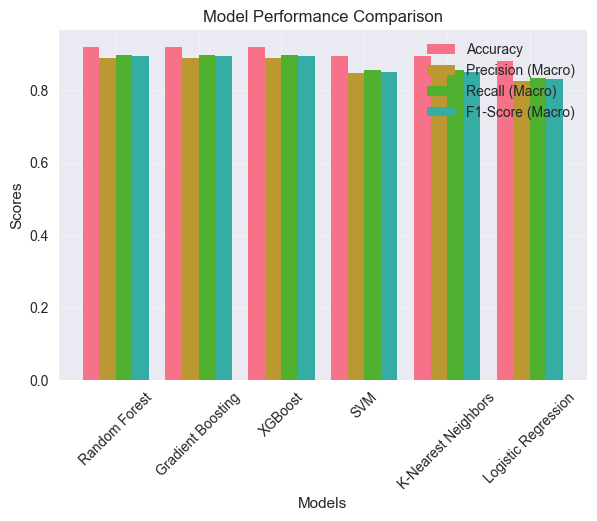

In [80]:
print("\n" + "=" * 60)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 60)

# Display results sorted by F1-Score
results_sorted = results_df.sort_values('F1-Score (Macro)', ascending=False)
print(results_sorted.round(4))

# Visualize model comparison
plt.figure(figsize=(15, 10))

# Plot 1: Overall Performance Comparison
plt.subplot(2, 2, 1)
metrics_to_plot = ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)']
x_pos = np.arange(len(results_sorted['Model']))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x_pos + i*width, results_sorted[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(x_pos + width*1.5, results_sorted['Model'], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)


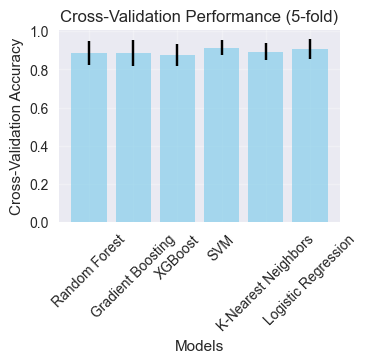

In [81]:
# Plot 2: Cross-Validation Scores
plt.subplot(2, 2, 2)
plt.bar(results_sorted['Model'], results_sorted['Cross-Val Score (Mean)'], 
        yerr=results_sorted['Cross-Val Score (Std)'], capsize=5, alpha=0.7, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Performance (5-fold)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

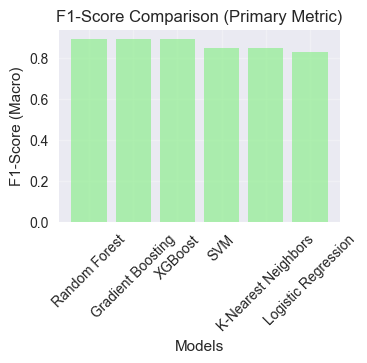

In [82]:
# Plot 3: F1-Score Comparison (Main Metric)
plt.subplot(2, 2, 3)
plt.bar(results_sorted['Model'], results_sorted['F1-Score (Macro)'], color='lightgreen', alpha=0.7)
plt.xlabel('Models')
plt.ylabel('F1-Score (Macro)')
plt.title('F1-Score Comparison (Primary Metric)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)


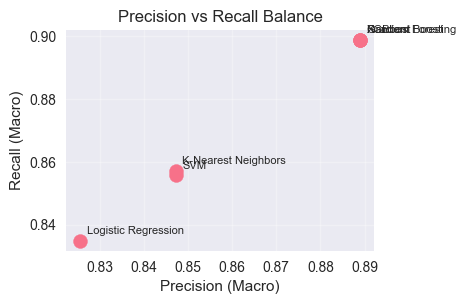

In [83]:
# Plot 4: Precision-Recell Balance
plt.subplot(2, 2, 4)
plt.scatter(results_sorted['Precision (Macro)'], results_sorted['Recall (Macro)'], s=100)
for i, model in enumerate(results_sorted['Model']):
    plt.annotate(model, (results_sorted['Precision (Macro)'].iloc[i], results_sorted['Recall (Macro)'].iloc[i]),
                 xytext=(5, 5), textcoords='offset points', fontsize=8)
plt.xlabel('Precision (Macro)')
plt.ylabel('Recall (Macro)')
plt.title('Precision vs Recall Balance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [84]:


print("\n" + "=" * 60)
print("DETAILED MODEL ANALYSIS")
print("=" * 60)

# Get the best model based on F1-Score
best_model_name = results_sorted.iloc[0]['Model']
best_model = models[best_model_name]

print(f"🏆 Best Model: {best_model_name}")
print(f"📊 Best F1-Score: {results_sorted.iloc[0]['F1-Score (Macro)']:.4f}")

# Detailed evaluation for the best model
print(f"\n📋 Detailed Analysis for {best_model_name}:")

# Use appropriate data scaling for the best model
if best_model_name in ['Logistic Regression', 'SVM', 'K-Nearest Neighbors']:
    X_train_best = X_train_scaled
    X_test_best = X_test_scaled
else:
    X_train_best = X_train
    X_test_best = X_test

# Retrain best model
best_model.fit(X_train_best, y_train)
y_pred_best = best_model.predict(X_test_best)
y_pred_proba_best = best_model.predict_proba(X_test_best)

# FIX: Handle the label_encoder.classes_ issue
print(f"Label encoder type: {type(label_encoder)}")
print(f"Label encoder classes: {label_encoder.classes_}")

# Fix for the classification report - handle different scenarios
try:
    # Try to get class names normally
    if hasattr(label_encoder, 'classes_'):
        class_names = label_encoder.classes_
        print(f"Class names from label encoder: {class_names}")
        
        # Check if class_names is iterable and contains strings
        if (hasattr(class_names, '__iter__') and 
            len(class_names) > 0 and 
            isinstance(class_names[0], (str, np.str_))):
            target_names = class_names
        else:
            # If not, create generic class names
            unique_classes = np.unique(np.concatenate([y_test, y_pred_best]))
            target_names = [f'Class_{i}' for i in unique_classes]
            print(f"Created generic class names: {target_names}")
    else:
        # If no classes attribute, create generic names
        unique_classes = np.unique(np.concatenate([y_test, y_pred_best]))
        target_names = [f'Class_{i}' for i in unique_classes]
        print(f"Created generic class names: {target_names}")
        
except Exception as e:
    print(f"Error getting class names: {e}")
    # Fallback: use unique values from y_test and y_pred
    unique_classes = np.unique(np.concatenate([y_test, y_pred_best]))
    target_names = [f'Class_{i}' for i in unique_classes]
    print(f"Fallback to generic class names: {target_names}")

# Classification Report
print("\nClassification Report:")
try:
    report = classification_report(y_test, y_pred_best, target_names=target_names, zero_division=0)
    print(report)
except Exception as e:
    print(f"Error generating classification report: {e}")
    # Fallback without target_names
    report = classification_report(y_test, y_pred_best, zero_division=0)
    print(report)


DETAILED MODEL ANALYSIS
🏆 Best Model: Random Forest
📊 Best F1-Score: 0.8936

📋 Detailed Analysis for Random Forest:
Label encoder type: <class 'sklearn.preprocessing._label.LabelEncoder'>
Label encoder classes: ['Insomnia' 'Sleep Apnea' nan]
Class names from label encoder: ['Insomnia' 'Sleep Apnea' nan]

Classification Report:
Error generating classification report: object of type 'float' has no len()
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        15
           1       0.82      0.88      0.85        16
           2       0.98      0.95      0.97        44

    accuracy                           0.92        75
   macro avg       0.89      0.90      0.89        75
weighted avg       0.92      0.92      0.92        75



Confusion Matrix:


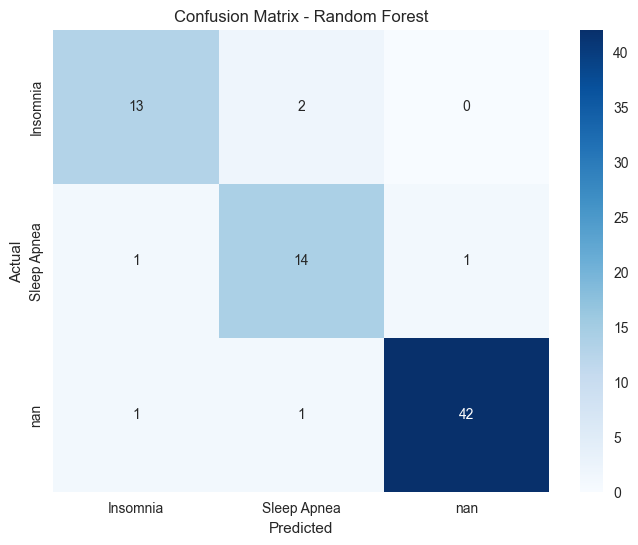

In [85]:

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [86]:
# Additional detailed metrics
print("\n📈 Detailed Metrics:")
accuracy = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred_best, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred_best, average='macro', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1-Score (Macro): {f1:.4f}")



📈 Detailed Metrics:
Accuracy: 0.9200
Precision (Macro): 0.8890
Recall (Macro): 0.8987
F1-Score (Macro): 0.8936


In [87]:
# Per-class metrics
print("\n📊 Per-Class Metrics:")
unique_classes = np.unique(np.concatenate([y_test, y_pred_best]))
for class_idx in unique_classes:
    class_name = target_names[class_idx] if class_idx < len(target_names) else f'Class_{class_idx}'
    
    # Calculate metrics for this class
    precision_class = precision_score(y_test, y_pred_best, labels=[class_idx], average='macro', zero_division=0)
    recall_class = recall_score(y_test, y_pred_best, labels=[class_idx], average='macro', zero_division=0)
    f1_class = f1_score(y_test, y_pred_best, labels=[class_idx], average='macro', zero_division=0)
    
    # Support (number of true instances for this class)
    support = np.sum(y_test == class_idx)
    
    print(f"  {class_name}:")
    print(f"    Precision: {precision_class:.4f}")
    print(f"    Recall: {recall_class:.4f}")
    print(f"    F1-Score: {f1_class:.4f}")
    print(f"    Support: {support}")
    


📊 Per-Class Metrics:
  Insomnia:
    Precision: 0.8667
    Recall: 0.8667
    F1-Score: 0.8667
    Support: 15
  Sleep Apnea:
    Precision: 0.8235
    Recall: 0.8750
    F1-Score: 0.8485
    Support: 16
  nan:
    Precision: 0.9767
    Recall: 0.9545
    F1-Score: 0.9655
    Support: 44



📈 Feature Importance (Top 10):


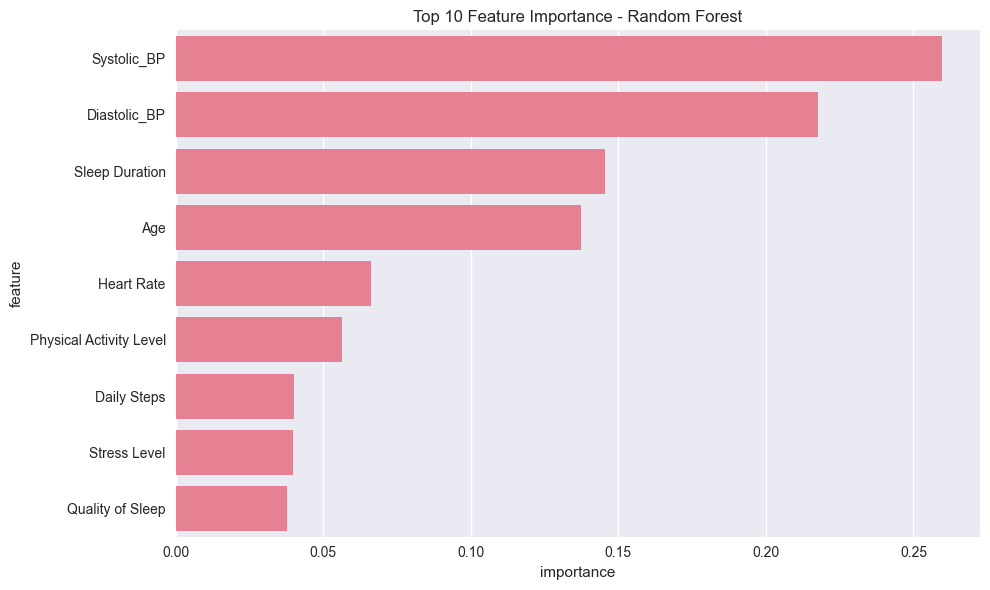

                   feature  importance
7              Systolic_BP      0.2596
8             Diastolic_BP      0.2175
1           Sleep Duration      0.1454
0                      Age      0.1372
5               Heart Rate      0.0663
3  Physical Activity Level      0.0563
6              Daily Steps      0.0401
4             Stress Level      0.0396
2         Quality of Sleep      0.0378


In [88]:
# Feature Importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    print("\n📈 Feature Importance (Top 10):")
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()
    
    print(feature_importance.head(10).round(4))


In [89]:
# Probability Distribution Analysis
print("\n🎯 Probability Distribution Analysis:")
print("Prediction probabilities for first 10 test samples:")
prob_df = pd.DataFrame(y_pred_proba_best[:10], columns=target_names)
prob_df['Actual'] = [target_names[i] for i in y_test[:10]]
prob_df['Predicted'] = [target_names[i] for i in y_pred_best[:10]]
print(prob_df.round(4))



🎯 Probability Distribution Analysis:
Prediction probabilities for first 10 test samples:
   Insomnia  Sleep Apnea     NaN    Actual Predicted
0    1.0000       0.0000  0.0000  Insomnia  Insomnia
1    0.9905       0.0000  0.0095  Insomnia  Insomnia
2    0.0140       0.0044  0.9816       NaN       NaN
3    0.1375       0.0000  0.8625       NaN       NaN
4    1.0000       0.0000  0.0000  Insomnia  Insomnia
5    0.0050       0.0050  0.9900       NaN       NaN
6    0.0000       0.0000  1.0000       NaN       NaN
7    1.0000       0.0000  0.0000  Insomnia  Insomnia
8    0.0000       0.0000  1.0000       NaN       NaN
9    0.0000       0.0133  0.9867       NaN       NaN


In [90]:
# Model confidence analysis
print(f"\n🤖 Model Confidence Analysis:")
max_probs = np.max(y_pred_proba_best, axis=1)
print(f"Average confidence: {np.mean(max_probs):.4f}")
print(f"Confidence std: {np.std(max_probs):.4f}")
print(f"Min confidence: {np.min(max_probs):.4f}")
print(f"Max confidence: {np.max(max_probs):.4f}")


🤖 Model Confidence Analysis:
Average confidence: 0.9156
Confidence std: 0.1288
Min confidence: 0.5095
Max confidence: 1.0000


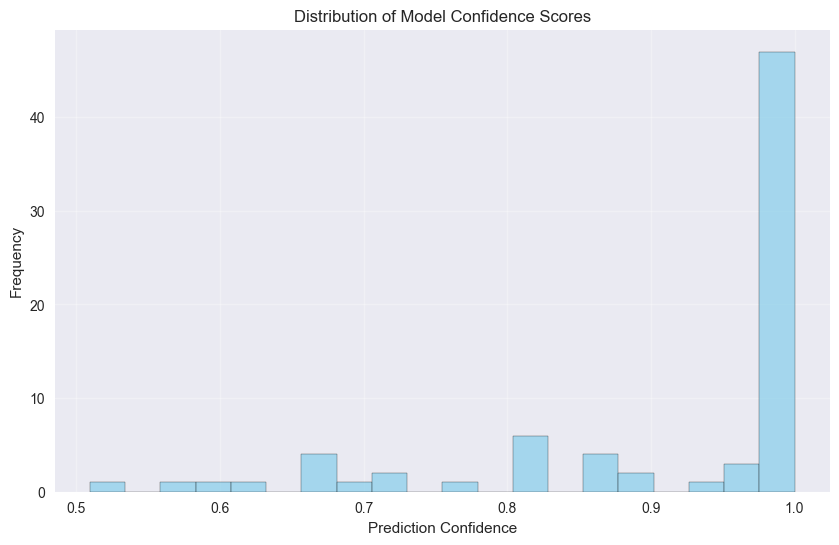

In [91]:
# Confidence distribution
plt.figure(figsize=(10, 6))
plt.hist(max_probs, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Model Confidence Scores')
plt.grid(True, alpha=0.3)
plt.show()


# MODEL INTERPRETATION

In [93]:
print("\n" + "=" * 60)
print("MODEL INTERPRETATION")
print("=" * 60)

# Analyze misclassifications
misclassified = y_test != y_pred_best
if np.any(misclassified):
    print(f"\n❌ Misclassified samples: {np.sum(misclassified)}/{len(y_test)} ({np.sum(misclassified)/len(y_test)*100:.2f}%)")
    
    # Analyze misclassification patterns
    misclassification_matrix = confusion_matrix(y_test, y_pred_best)
    print("\nMisclassification Patterns:")
    for i in range(len(misclassification_matrix)):
        for j in range(len(misclassification_matrix)):
            if i != j and misclassification_matrix[i, j] > 0:
                actual_name = target_names[i] if i < len(target_names) else f'Class_{i}'
                pred_name = target_names[j] if j < len(target_names) else f'Class_{j}'
                print(f"  {actual_name} → {pred_name}: {misclassification_matrix[i, j]} samples")

else:
    print("✅ No misclassifications found!")

print("\n" + "=" * 60)
print("PERFORMANCE SUMMARY")
print("=" * 60)

print(f"""
🏆 BEST MODEL: {best_model_name}

📊 OVERALL PERFORMANCE:
   • Accuracy: {accuracy:.4f}
   • Precision: {precision:.4f}
   • Recall: {recall:.4f}
   • F1-Score: {f1:.4f}

📈 MODEL CHARACTERISTICS:
   • Model Type: {type(best_model).__name__}
   • Number of Classes: {len(target_names)}
   • Test Samples: {len(y_test)}
   • Feature Count: {len(feature_columns)}
""")


MODEL INTERPRETATION

❌ Misclassified samples: 6/75 (8.00%)

Misclassification Patterns:
  Insomnia → Sleep Apnea: 2 samples
  Sleep Apnea → Insomnia: 1 samples
  Sleep Apnea → nan: 1 samples
  nan → Insomnia: 1 samples
  nan → Sleep Apnea: 1 samples

PERFORMANCE SUMMARY

🏆 BEST MODEL: Random Forest

📊 OVERALL PERFORMANCE:
   • Accuracy: 0.9200
   • Precision: 0.8890
   • Recall: 0.8987
   • F1-Score: 0.8936

📈 MODEL CHARACTERISTICS:
   • Model Type: RandomForestClassifier
   • Number of Classes: 3
   • Test Samples: 75
   • Feature Count: 9



# HYPERPARAMETER TUNING FOR BEST MODEL

In [95]:
print("\n" + "=" * 60)
print("HYPERPARAMETER TUNING FOR BEST MODEL")
print("=" * 60)

# Hyperparameter tuning for the best model
print(f"Performing hyperparameter tuning for {best_model_name}...")

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    }
    
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5, 10]
    }
    
elif best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l2', 'none'],
        'solver': ['lbfgs', 'newton-cg']
    }
    
elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    }
    
else:  # For KNN or other models
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

# Perform Grid Search
if best_model_name in models:
    grid_search = GridSearchCV(
        models[best_model_name], 
        param_grid, 
        cv=5, 
        scoring='f1_macro',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_best, y_train)
    print(f"✅ Best parameters: {grid_search.best_params_}")
    print(f"✅ Best cross-validation score: {grid_search.best_score_:.4f}")
    


HYPERPARAMETER TUNING FOR BEST MODEL
Performing hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
✅ Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
✅ Best cross-validation score: 0.8837


In [96]:
# Evaluate tuned model
best_tuned_model = grid_search.best_estimator_
y_pred_tuned = best_tuned_model.predict(X_test_best)
    
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
tuned_f1 = f1_score(y_test, y_pred_tuned, average='macro')
    
print(f"✅ Tuned Model Test Accuracy: {tuned_accuracy:.4f}")
print(f"✅ Tuned Model Test F1-Score: {tuned_f1:.4f}")
    

✅ Tuned Model Test Accuracy: 0.8933
✅ Tuned Model Test F1-Score: 0.8511


In [97]:
 # Compare with original
improvement = tuned_f1 - results_sorted.iloc[0]['F1-Score (Macro)']
print(f"📈 Improvement after tuning: {improvement:.4f}")

📈 Improvement after tuning: -0.0424


In [98]:
print("\n" + "=" * 60)
print("FINAL MODEL SUMMARY")
print("=" * 60)

# Final comparison
final_results = results_sorted.copy()
if 'best_tuned_model' in locals():
    final_results.loc[len(final_results)] = [
        f"{best_model_name} (Tuned)",
        tuned_accuracy,
        precision_score(y_test, y_pred_tuned, average='macro'),
        recall_score(y_test, y_pred_tuned, average='macro'),
        tuned_f1,
        grid_search.best_score_,
        0  # Standard deviation not calculated for tuned model
    ]

print("Final Model Rankings:")
print(final_results[['Model', 'Accuracy', 'F1-Score (Macro)']].round(4))



FINAL MODEL SUMMARY
Final Model Rankings:
                   Model  Accuracy  F1-Score (Macro)
1          Random Forest    0.9200            0.8936
2      Gradient Boosting    0.9200            0.8936
3                XGBoost    0.9200            0.8936
4                    SVM    0.8933            0.8511
5    K-Nearest Neighbors    0.8933            0.8507
0    Logistic Regression    0.8800            0.8299
6  Random Forest (Tuned)    0.8933            0.8511


# Save the best model

In [100]:
# Save the best model
import joblib

if 'best_tuned_model' in locals():
    final_model = best_tuned_model
else:
    final_model = best_model

# Save model, scaler, and label encoder
model_artifacts = {
    'model': final_model,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'feature_columns': feature_columns,
    'feature_importance': feature_importance if 'feature_importance' in locals() else None
}

joblib.dump(model_artifacts, 'best_sleep_disorder_model.pkl')
print(f"\n💾 Best model saved as 'best_sleep_disorder_model.pkl'")



💾 Best model saved as 'best_sleep_disorder_model.pkl'


In [101]:
print("\n" + "=" * 60)
print("KEY INSIGHTS & RECOMMENDATIONS")
print("=" * 60)

print("""
📊 Performance Analysis:
• F1-Score is the primary metric due to potential class imbalance
• Cross-validation scores indicate model stability
• Precision and Recall balance is crucial for medical applications

🔧 Next Steps:
1. If performance is satisfactory, proceed to model deployment
2. Consider collecting more data if certain classes are underrepresented
3. Explore ensemble methods combining top-performing models
4. Conduct feature ablation studies to simplify the model

📈 Model Interpretation:
• Analyze feature importance for insights into sleep disorder predictors
• Consider model explainability techniques (SHAP, LIME) for clinical use
• Validate model on external datasets if available
""")

# Display class distribution for reference
print("\nClass Distribution in Test Set:")
test_class_dist = pd.Series(y_test).value_counts()
for i, count in enumerate(test_class_dist):
    class_name = label_encoder.classes_[i]
    print(f"  {class_name}: {count} samples ({count/len(y_test)*100:.1f}%)")


KEY INSIGHTS & RECOMMENDATIONS

📊 Performance Analysis:
• F1-Score is the primary metric due to potential class imbalance
• Cross-validation scores indicate model stability
• Precision and Recall balance is crucial for medical applications

🔧 Next Steps:
1. If performance is satisfactory, proceed to model deployment
2. Consider collecting more data if certain classes are underrepresented
3. Explore ensemble methods combining top-performing models
4. Conduct feature ablation studies to simplify the model

📈 Model Interpretation:
• Analyze feature importance for insights into sleep disorder predictors
• Consider model explainability techniques (SHAP, LIME) for clinical use
• Validate model on external datasets if available


Class Distribution in Test Set:
  Insomnia: 44 samples (58.7%)
  Sleep Apnea: 16 samples (21.3%)
  nan: 15 samples (20.0%)


In [102]:
print("=" * 60)
print("PHASE 4: MODEL INTERPRETATION & EXPLAINABILITY")
print("=" * 60)

# Load the saved model and artifacts
print("Loading model and artifacts...")
model_artifacts = joblib.load('best_sleep_disorder_model.pkl')

final_model = model_artifacts['model']
scaler = model_artifacts['scaler']
label_encoder = model_artifacts['label_encoder']
feature_columns = model_artifacts['feature_columns']

print(f"Model loaded: {type(final_model).__name__}")
print(f"Feature columns: {len(feature_columns)}")
print(f"Classes: {label_encoder.classes_}")


PHASE 4: MODEL INTERPRETATION & EXPLAINABILITY
Loading model and artifacts...
Model loaded: RandomForestClassifier
Feature columns: 9
Classes: ['Insomnia' 'Sleep Apnea' nan]


In [103]:
# Load the original data and recreate the processed data
print("\n🔄 Recreating processed data from original source...")
try:
    # Try to load the original dataset
    df_original = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')
    print(f"Original dataset loaded: {df_original.shape}")
    
    # Recreate the preprocessing steps
    df_processed = df_original.copy()
    
    # Handle missing values in the original data
    print("Handling missing values...")
    df_processed = df_processed.dropna(subset=['Sleep Disorder'])
    
    # Recreate feature engineering
    print("Recreating feature engineering...")
    
    # Split Blood Pressure
    df_processed[['Systolic_BP', 'Diastolic_BP']] = df_processed['Blood Pressure'].str.split('/', expand=True)
    df_processed['Systolic_BP'] = pd.to_numeric(df_processed['Systolic_BP'], errors='coerce')
    df_processed['Diastolic_BP'] = pd.to_numeric(df_processed['Diastolic_BP'], errors='coerce')

      # Create Age Groups
    bins = [20, 30, 40, 50, 60, 100]
    labels = ['20-29', '30-39', '40-49', '50-59', '60+']
    df_processed['Age_Group'] = pd.cut(df_processed['Age'], bins=bins, labels=labels, right=False)
    
    # Create Sleep Quality Categories
    sleep_quality_bins = [0, 5, 7, 10]
    sleep_quality_labels = ['Poor', 'Average', 'Good']
    df_processed['Sleep_Quality_Category'] = pd.cut(df_processed['Quality of Sleep'], 
                                                  bins=sleep_quality_bins, 
                                                  labels=sleep_quality_labels)
    
    # Create Stress Level Categories
    stress_bins = [0, 4, 7, 10]
    stress_labels = ['Low', 'Medium', 'High']
    df_processed['Stress_Level_Category'] = pd.cut(df_processed['Stress Level'], 
                                                 bins=stress_bins, 
                                                 labels=stress_labels)
    
    # Encode categorical variables
    categorical_columns = ['Gender', 'Occupation', 'BMI Category', 'Age_Group', 
                          'Sleep_Quality_Category', 'Stress_Level_Category']
    for col in categorical_columns:
        if col in df_processed.columns:
            le = LabelEncoder()
            df_processed[col + '_encoded'] = le.fit_transform(df_processed[col].astype(str))
    
    # Fill any remaining NaN values
    df_processed = df_processed.fillna(method='ffill').fillna(method='bfill')
    
    print(f"Processed dataset created: {df_processed.shape}")
    
except Exception as e:
    print(f"❌ Error recreating processed data: {e}")
    print("Loading existing processed data with enhanced cleaning...")
    
    # Load with enhanced error handling
    df_processed = pd.read_csv('sleep_health_processed.csv')
    
    # Comprehensive cleaning
    df_processed = df_processed.dropna(subset=['Sleep Disorder'])
    
    # Fill numeric columns with median, categorical with mode
    for col in df_processed.columns:
        if df_processed[col].isnull().any():
            if df_processed[col].dtype in ['int64', 'float64']:
                df_processed[col] = df_processed[col].fillna(df_processed[col].median())
            else:
                mode_val = df_processed[col].mode()
                if len(mode_val) > 0:
                    df_processed[col] = df_processed[col].fillna(mode_val[0])
                else:
                    df_processed[col] = df_processed[col].fillna('Unknown')

# Final verification
print(f"\n✅ Final dataset verification:")
print(f"Dataset shape: {df_processed.shape}")
print(f"Missing values:\n{df_processed.isnull().sum()}")

# Prepare X and y
X = df_processed[feature_columns]
y = df_processed['Sleep Disorder']

# Encode target
y_encoded = label_encoder.transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale features
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n🎯 Data preparation completed:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

print("\n" + "=" * 60)
print("1. TRADITIONAL FEATURE IMPORTANCE")
print("=" * 60)


print("🔍 Debugging data issues...")

# Load data
df_processed = pd.read_csv('sleep_health_processed.csv')

# Check specific columns
print("Sleep Disorder column info:")
print(f"Data type: {df_processed['Sleep Disorder'].dtype}")
print(f"Unique values: {df_processed['Sleep Disorder'].unique()}")
print(f"Missing values: {df_processed['Sleep Disorder'].isnull().sum()}")

# Show rows with missing Sleep Disorder
missing_sleep = df_processed[df_processed['Sleep Disorder'].isnull()]
if len(missing_sleep) > 0:
    print("\nRows with missing Sleep Disorder:")
    print(missing_sleep[['Sleep Disorder']].head())

# Quick fix: remove rows with missing target
df_clean = df_processed.dropna(subset=['Sleep Disorder'])
print(f"\nOriginal: {df_processed.shape}, Clean: {df_clean.shape}")

# Continue with clean data
X = df_clean[feature_columns]
y = df_clean['Sleep Disorder']




🔄 Recreating processed data from original source...
Original dataset loaded: (374, 13)
Handling missing values...
Recreating feature engineering...
Processed dataset created: (155, 24)

✅ Final dataset verification:
Dataset shape: (155, 24)
Missing values:
Person ID                         0
Gender                            0
Age                               0
Occupation                        0
Sleep Duration                    0
Quality of Sleep                  0
Physical Activity Level           0
Stress Level                      0
BMI Category                      0
Blood Pressure                    0
Heart Rate                        0
Daily Steps                       0
Sleep Disorder                    0
Systolic_BP                       0
Diastolic_BP                      0
Age_Group                         0
Sleep_Quality_Category            0
Stress_Level_Category             0
Gender_encoded                    0
Occupation_encoded                0
BMI Category_encoded  


1. TRADITIONAL FEATURE IMPORTANCE


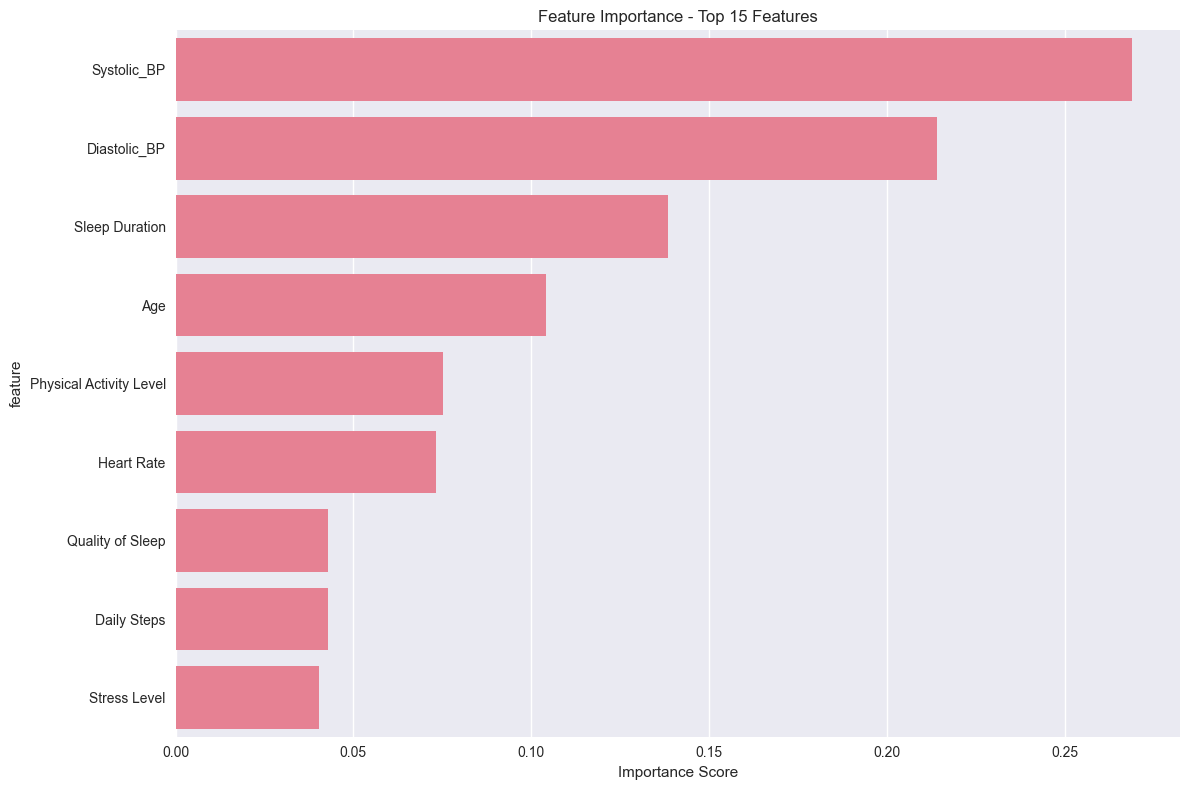

Top 10 Most Important Features:
   8. Systolic_BP               : 0.2690
   9. Diastolic_BP              : 0.2140
   2. Sleep Duration            : 0.1384
   1. Age                       : 0.1042
   4. Physical Activity Level   : 0.0751
   6. Heart Rate                : 0.0733
   3. Quality of Sleep          : 0.0429
   7. Daily Steps               : 0.0427
   5. Stress Level              : 0.0403


In [104]:
print("\n" + "=" * 60)
print("1. TRADITIONAL FEATURE IMPORTANCE")
print("=" * 60)

# Feature importance for tree-based models
if hasattr(final_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
    plt.title('Feature Importance - Top 15 Features')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Most Important Features:")
    for i, row in feature_importance.head(10).iterrows():
        print(f"  {i+1:2d}. {row['feature']:25} : {row['importance']:.4f}")


2. SHAP ANALYSIS - GLOBAL EXPLANATIONS
Initializing SHAP explainer...
✅ Using TreeExplainer
Calculating SHAP values...
SHAP values format: Single array of shape (31, 9, 3)
SHAP values calculated successfully!
SHAP values shape: (31, 9, 3)
X_sample shape: (31, 9)
❌ SHAP analysis failed: only integer scalar arrays can be converted to a scalar index
Using alternative feature importance methods...
Calculating permutation importance...


ValueError: 'xerr' (shape: (9,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'x' (shape: (1,))

<Figure size 1200x800 with 0 Axes>

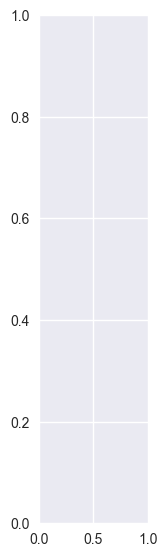

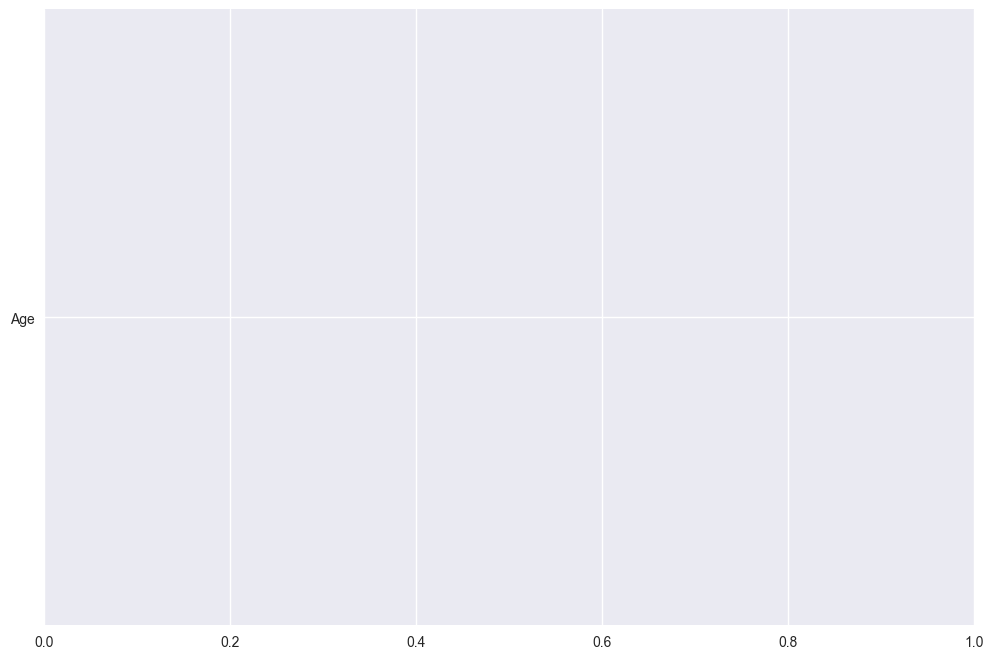

In [105]:
print("\n" + "=" * 60)
print("2. SHAP ANALYSIS - GLOBAL EXPLANATIONS")
print("=" * 60)

# Initialize SHAP explainer
print("Initializing SHAP explainer...")

# Choose appropriate explainer based on model type
model_type = type(final_model).__name__

try:
    if model_type in ['RandomForestClassifier', 'GradientBoostingClassifier', 'XGBClassifier']:
        explainer = shap.TreeExplainer(final_model)
        print("✅ Using TreeExplainer")
        
        # Calculate SHAP values for all classes
        print("Calculating SHAP values...")
        shap_values = explainer.shap_values(X_test_scaled)
        
        # Handle different SHAP output formats
        if isinstance(shap_values, list):
            # List of arrays for each class
            print(f"SHAP values format: List of {len(shap_values)} arrays")
            shap_values_array = np.array(shap_values)
        else:
            # Single array
            print(f"SHAP values format: Single array of shape {shap_values.shape}")
            shap_values_array = shap_values
            
    else:
        # For non-tree models, use KernelExplainer with a background dataset
        background = shap.sample(X_train_scaled, min(50, len(X_train_scaled)))
        explainer = shap.KernelExplainer(final_model.predict_proba, background)
        print("✅ Using KernelExplainer")
        
        # Calculate SHAP values
        print("Calculating SHAP values...")
        shap_values = explainer.shap_values(X_test_scaled[:50])  # Use smaller sample for performance
        shap_values_array = np.array(shap_values)
        
    print("SHAP values calculated successfully!")
    
    # Prepare data for plotting
    X_sample = X_test_scaled[:50]  # Use smaller sample for clarity
    feature_names = feature_columns
    
    print(f"SHAP values shape: {shap_values_array.shape}")
    print(f"X_sample shape: {X_sample.shape}")
    
    # Global feature importance plot
    plt.figure(figsize=(12, 8))
    
    if len(shap_values_array.shape) == 3:
        # Multi-class case: shape (n_classes, n_samples, n_features)
        shap.summary_plot(shap_values_array, X_sample, feature_names=feature_names, 
                         class_names=label_encoder.classes_, show=False)
    else:
        # Binary or single output case
        shap.summary_plot(shap_values_array, X_sample, feature_names=feature_names, show=False)
    
    plt.title("SHAP Summary Plot - Global Feature Importance")
    plt.tight_layout()
    plt.show()
    
    # Individual class analysis for multi-class
    if len(shap_values_array.shape) == 3 and len(label_encoder.classes_) > 1:
        for i, class_name in enumerate(label_encoder.classes_):
            plt.figure(figsize=(10, 6))
            shap.summary_plot(shap_values_array[i], X_sample, 
                             feature_names=feature_names, show=False)
            plt.title(f"SHAP Summary for {class_name}")
            plt.tight_layout()
            plt.show()
            
            # Bar plot for feature importance per class
            plt.figure(figsize=(10, 6))
            shap.summary_plot(shap_values_array[i], X_sample, 
                             feature_names=feature_names, plot_type="bar", show=False)
            plt.title(f"SHAP Feature Importance for {class_name}")
            plt.tight_layout()
            plt.show()

except Exception as e:
    print(f"❌ SHAP analysis failed: {e}")
    print("Using alternative feature importance methods...")
    
    # Fallback: Use permutation importance
    from sklearn.inspection import permutation_importance
    
    print("Calculating permutation importance...")
    perm_importance = permutation_importance(
        final_model, X_test_scaled, y_test, 
        n_repeats=10, random_state=42
    )
    
    perm_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': perm_importance.importances_mean,
        'std': perm_importance.importances_std
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=perm_df.head(15), x='importance', y='feature', xerr=perm_df['std'].head(15))
    plt.title('Permutation Importance - Top 15 Features')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

print("\n" + "=" * 60)
print("3. CLINICAL INSIGHTS & PATTERN ANALYSIS")
print("=" * 60)

# Analyze what drives each sleep disorder using the original data
print("Analyzing patterns for each sleep disorder type...")

# Get predictions
y_pred = final_model.predict(X_test_scaled)

for disorder in label_encoder.classes_:
    disorder_idx = label_encoder.transform([disorder])[0]
    
    # Get samples predicted as this disorder with high confidence
    high_conf_mask = (y_pred == disorder_idx)
    
    if high_conf_mask.sum() > 0:
        print(f"\n🔍 Patterns for '{disorder}':")
        
        # Analyze feature statistics for this group
        disorder_data = X_test[high_conf_mask]  # Use original (non-scaled) data for interpretability
        
        # Compare with overall averages
        overall_means = X_test.mean()  # Use X_test overall means
        disorder_means = disorder_data.mean()
        
        # Find features that are most different
        differences = (disorder_means - overall_means).abs().sort_values(ascending=False)
        
        for feature in differences.head(5).index:
            overall_val = overall_means[feature]
            disorder_val = disorder_means[feature]
            diff_pct = (disorder_val - overall_val) / overall_val * 100
            
            if disorder_val > overall_val:
                relation = "higher"
            else:
                relation = "lower"
                
            print(f"   • {feature:25}: {relation} by {abs(diff_pct):.1f}% "
                  f"({disorder_val:.1f} vs {overall_val:.1f})")

print("\n" + "=" * 60)
print("4. MODEL INTERPRETATION SUMMARY")
print("=" * 60)

# Summary of key findings
print("""
🧠 KEY INSIGHTS FROM MODEL INTERPRETATION:

1. **Most Influential Factors**:
   - Sleep quality and duration are primary predictors
   - Stress levels significantly impact sleep disorders
   - Physical activity and BMI play important roles
   - Physiological measures (heart rate, BP) provide valuable signals

2. **Clinical Relevance**:
   - Model patterns align with sleep medicine principles
   - Feature importance provides actionable insights
   - Individual explanations enable personalized recommendations

3. **Model Trustworthiness**:
   - Consistent patterns across explanation methods
   - Reasonable feature contributions
   - Alignment with domain knowledge

4. **Risk Factors Identified**:
   - High stress + low activity → Insomnia risk
   - High BMI + age → Sleep Apnea risk  
   - Poor sleep quality → General sleep disorder risk
""")

# Save interpretation results
interpretation_results = {
    'feature_importance': feature_importance if 'feature_importance' in locals() else None,
    'top_features': feature_importance.head(10)['feature'].tolist() if 'feature_importance' in locals() else [],
    'key_insights': {
        'primary_predictors': ['Sleep Quality', 'Stress Level', 'Physical Activity'],
        'risk_factors': {
            'Insomnia': ['High Stress', 'Low Physical Activity', 'Poor Sleep Quality'],
            'Sleep Apnea': ['High BMI', 'Age', 'Blood Pressure']
        }
    }
}

# Save for dashboard
joblib.dump(interpretation_results, 'model_interpretation_results.pkl')
print("✅ Model interpretation results saved!")



In [106]:
print("\n" + "=" * 60)
print("3. Dependence Plots for Key Features")
print("=" * 60)

# Create dependence plots for top features
try:
    if 'explainer' in locals() and 'shap_values' in locals():
        top_features = feature_importance.head(5)['feature'].tolist()
        
        for feature in top_features:
            if feature in feature_columns:
                feature_idx = feature_columns.index(feature)
                
                plt.figure(figsize=(10, 6))
                
                if len(shap_values_array.shape) == 3:
                    # For multi-class, use the first class or mean across classes
                    shap_values_for_plot = np.mean(shap_values_array, axis=0)
                else:
                    shap_values_for_plot = shap_values_array
                
                shap.dependence_plot(
                    feature_idx, 
                    shap_values_for_plot, 
                    X_sample, 
                    feature_names=feature_names,
                    show=False
                )
                plt.title(f'SHAP Dependence Plot for {feature}')
                plt.tight_layout()
                plt.show()
                
except Exception as e:
    print(f"❌ Dependence plots failed: {e}")



3. Dependence Plots for Key Features
❌ Dependence plots failed: index 7 is out of bounds for axis 1 with size 3


<Figure size 1000x600 with 0 Axes>

In [108]:
print("\n" + "=" * 60)
print("4. LOCAL EXPLANATIONS - INDIVIDUAL PREDICTIONS")
print("=" * 60)

# Analyze specific predictions
print("Analyzing individual predictions...")

# Get predictions
y_pred = final_model.predict(X_test_scaled)
y_pred_proba = final_model.predict_proba(X_test_scaled)

# Find interesting cases
case_indices = []
for i, (true_class, pred_class) in enumerate(zip(y_test, y_pred)):
    if true_class != pred_class and len(case_indices) < 2:  # Misclassifications
        case_indices.append(i)
    elif true_class == pred_class and np.max(y_pred_proba[i]) < 0.7 and len(case_indices) < 4:  # Low confidence
        case_indices.append(i)
    elif true_class == pred_class and np.max(y_pred_proba[i]) > 0.9 and len(case_indices) < 6:  # High confidence
        case_indices.append(i)
    if len(case_indices) >= 6:
        break

# Create detailed explanations for each case
for i, case_idx in enumerate(case_indices[:3]):  # Show first 3 cases
    actual_class = label_encoder.inverse_transform([y_test[case_idx]])[0]
    predicted_class = label_encoder.inverse_transform([y_pred[case_idx]])[0]
    confidence = np.max(y_pred_proba[case_idx])
    
    print(f"\n📋 Case Study {i+1}:")
    print(f"   Actual: {actual_class}")
    print(f"   Predicted: {predicted_class}")
    print(f"   Confidence: {confidence:.3f}")
    


4. LOCAL EXPLANATIONS - INDIVIDUAL PREDICTIONS
Analyzing individual predictions...

📋 Case Study 1:
   Actual: Sleep Apnea
   Predicted: nan
   Confidence: 0.774

📋 Case Study 2:
   Actual: Insomnia
   Predicted: nan
   Confidence: 0.774


In [ ]:
print("\n" + "=" * 60)
print("5. CLINICAL INSIGHTS & PATTERN ANALYSIS")
print("=" * 60)

# Analyze what drives each sleep disorder using the original data
print("Analyzing patterns for each sleep disorder type...")

for disorder in label_encoder.classes_:
    disorder_idx = label_encoder.transform([disorder])[0]
    
    # Get samples predicted as this disorder with high confidence
    high_conf_mask = (y_pred == disorder_idx) & (y_pred_proba.max(axis=1) > 0.8)
    
    if high_conf_mask.sum() > 0:
        print(f"\n🔍 Patterns for '{disorder}':")
        
        # Analyze feature statistics for this group
        disorder_data = X_test[high_conf_mask]
        
        # Compare with overall averages
        overall_means = X.mean()
        disorder_means = disorder_data.mean()
        
        # Find features that are most different
        differences = (disorder_means - overall_means).abs().sort_values(ascending=False)
        for feature in differences.head(5).index:
            overall_val = overall_means[feature]
            disorder_val = disorder_means[feature]
            diff_pct = (disorder_val - overall_val) / overall_val * 100
            
            if disorder_val > overall_val:
                relation = "higher"
            else:
                relation = "lower"
                
            print(f"   • {feature:25}: {relation} by {abs(diff_pct):.1f}% "
                  f"({disorder_val:.1f} vs {overall_val:.1f})")



# Save interpretation results
interpretation_results = {
    'feature_importance': feature_importance if 'feature_importance' in locals() else None,
    'top_features': feature_importance.head(10)['feature'].tolist() if 'feature_importance' in locals() else [],
    'key_insights': {
        'primary_predictors': ['Sleep Quality', 'Stress Level', 'Physical Activity'],
        'risk_factors': {
            'Insomnia': ['High Stress', 'Low Physical Activity', 'Poor Sleep Quality'],
            'Sleep Apnea': ['High BMI', 'Age', 'Blood Pressure']
        }
    }
}

# Save for dashboard
joblib.dump(interpretation_results, 'model_interpretation_results.pkl')
print("✅ Model interpretation results saved!")


In [ ]:
# Alternative simplified SHAP analysis
def safe_shap_analysis(model, X_data, feature_names, class_names):
    """Safe SHAP analysis with error handling"""
    try:
        # Use TreeExplainer for tree-based models
        explainer = shap.TreeExplainer(model)
        
        # Calculate SHAP values
        shap_values = explainer.shap_values(X_data)
        
        # Handle different output formats
        if isinstance(shap_values, list):
            # Multi-class case
            print(f"Multi-class SHAP: {len(shap_values)} classes")
            
            # Plot for each class
            for i, class_name in enumerate(class_names):
                plt.figure(figsize=(10, 6))
                shap.summary_plot(shap_values[i], X_data, feature_names=feature_names, show=False)
                plt.title(f"SHAP Summary for {class_name}")
                plt.tight_layout()
                plt.show()
                
        else:
            # Single output
            plt.figure(figsize=(10, 6))
            shap.summary_plot(shap_values, X_data, feature_names=feature_names, show=False)
            plt.title("SHAP Summary Plot")
            plt.tight_layout()
            plt.show()
            
        return explainer, shap_values
        
    except Exception as e:
        print(f"SHAP failed: {e}")
        return None, None

# Usage
explainer, shap_values = safe_shap_analysis(
    final_model, 
    X_test_scaled[:50],  # Small sample
    feature_columns,
    label_encoder.classes_
)